In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette('Set2')
# Load dataset
df = pd.read_csv('../data/cleaned_fraud_dataset.csv')
print(f"Loaded dataset with {df.shape[0]} transactions and {df.shape[1]} columns")

# Basic stats
origin_accounts = set(df['nameOrig'])
dest_accounts = set(df['nameDest'])
all_accounts = origin_accounts.union(dest_accounts)

print(f"Total unique accounts: {len(all_accounts)}")
print(f"Unique origin accounts: {len(origin_accounts)}")
print(f"Unique destination accounts: {len(dest_accounts)}")
df.head()
# Calculate metrics for accounts
def calculate_account_metrics():
    incoming = df.groupby('nameDest').agg(
        incoming_count=('amount', 'count'),
        incoming_volume=('amount', 'sum')
    )
    outgoing = df.groupby('nameOrig').agg(
        outgoing_count=('amount', 'count'),
        outgoing_volume=('amount', 'sum')
    )
    metrics = pd.merge(incoming, outgoing, how='outer', left_index=True, right_index=True).fillna(0)
    metrics['retention_amount'] = metrics['incoming_volume'] - metrics['outgoing_volume']
    metrics['retention_rate'] = metrics.apply(
        lambda row: row['retention_amount'] / row['incoming_volume'] if row['incoming_volume'] > 0 else 0,
        axis=1
    )
    metrics.reset_index(inplace=True)
    metrics.rename(columns={'index': 'account'}, inplace=True)
    return metrics

account_metrics = calculate_account_metrics()
print(f"Calculated metrics for {len(account_metrics)} accounts")
account_metrics.head(10)


Loaded dataset with 2770409 transactions and 6 columns
Total unique accounts: 3277509
Unique origin accounts: 2768630
Unique destination accounts: 509565
Calculated metrics for 3277509 accounts


,account,incoming_count,incoming_volume,outgoing_count,outgoing_volume,retention_amount,retention_rate
0,C1000000639,0.0,0.00,1.0,244486.46,-244486.46,0.0
1,C1000004053,0.0,0.00,1.0,211189.64,-211189.64,0.0
2,C1000004082,3.0,1923026.06,0.0,0.00,1923026.06,1.0
3,C1000004530,0.0,0.00,1.0,93865.13,-93865.13,0.0
4,C1000004940,10.0,1878167.59,0.0,0.00,1878167.59,1.0
5,C1000005353,0.0,0.00,1.0,3228390.11,-3228390.11,0.0
6,C1000005555,0.0,0.00,1.0,233109.79,-233109.79,0.0
7,C1000005749,0.0,0.00,1.0,3229333.12,-3229333.12,0.0
8,C1000008236,0.0,0.00,1.0,673726.47,-673726.47,0.0
9,C1000008393,0.0,0.00,1.0,58347.84,-58347.84,0.0


Identified 168170 collector accounts
=== Collector Accounts Summary ===
Total accounts: 168170
Percentage of all accounts: 5.13
Total incoming volume: 673,590,548,464.32
Total outgoing volume: 45,638,968.54
Average incoming volume: 4,005,414.45
Average outgoing volume: 271.39
Average retention rate: 99.99
Total retained amount: 673,544,909,495.78


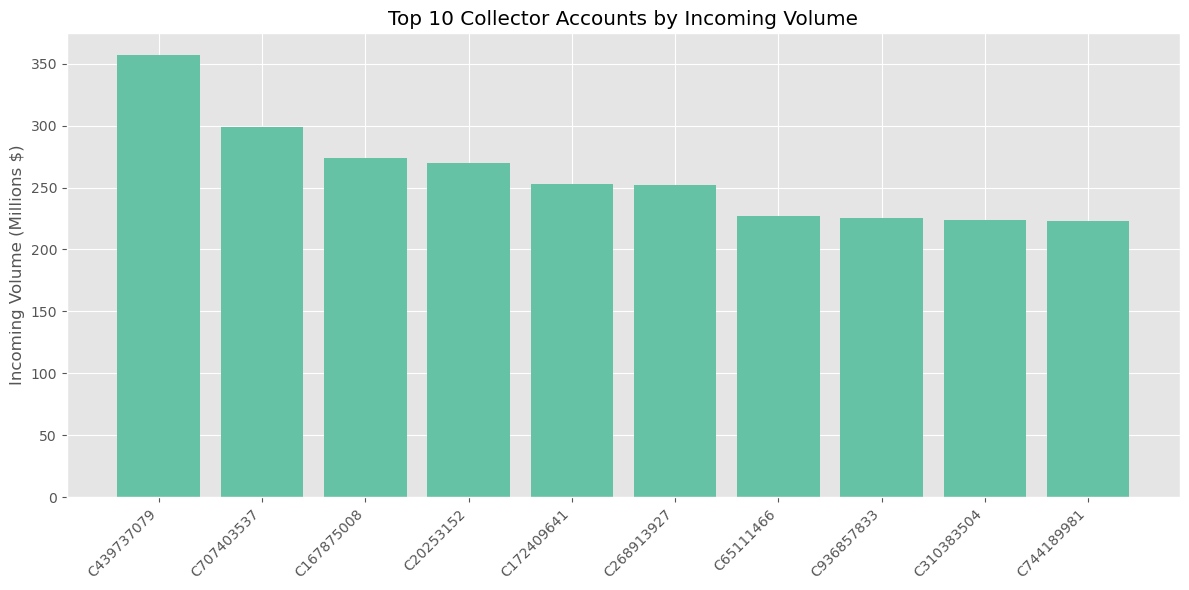

In [4]:
# Identify collector accounts
def is_collector(row):
    return (
        row['incoming_count'] > 5 and
        row['incoming_count'] > row['outgoing_count'] * 3 and
        row['retention_rate'] > 0.7
    )

collector_accounts = account_metrics[account_metrics.apply(is_collector, axis=1)].copy()
collector_accounts.sort_values('incoming_volume', ascending=False, inplace=True)

print(f"Identified {len(collector_accounts)} collector accounts")
collector_accounts.head(20)

# Summary stats for collectors
collector_summary = {
    'Total accounts': len(collector_accounts),
    'Percentage of all accounts': len(collector_accounts) / len(account_metrics) * 100,
    'Total incoming volume': collector_accounts['incoming_volume'].sum(),
    'Total outgoing volume': collector_accounts['outgoing_volume'].sum(),
    'Average incoming volume': collector_accounts['incoming_volume'].mean(),
    'Average outgoing volume': collector_accounts['outgoing_volume'].mean(),
    'Average retention rate': collector_accounts['retention_rate'].mean() * 100,
    'Total retained amount': collector_accounts['retention_amount'].sum()
}

print("=== Collector Accounts Summary ===")
for k, v in collector_summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}")


# Plot top collectors
plt.figure(figsize=(12, 6))
top_collectors = collector_accounts.head(10)
plt.bar(top_collectors['account'], top_collectors['incoming_volume'] / 1e6)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Incoming Volume (Millions $)')
plt.title('Top 10 Collector Accounts by Incoming Volume')
plt.tight_layout()
plt.show()



Identified 196 money mule accounts


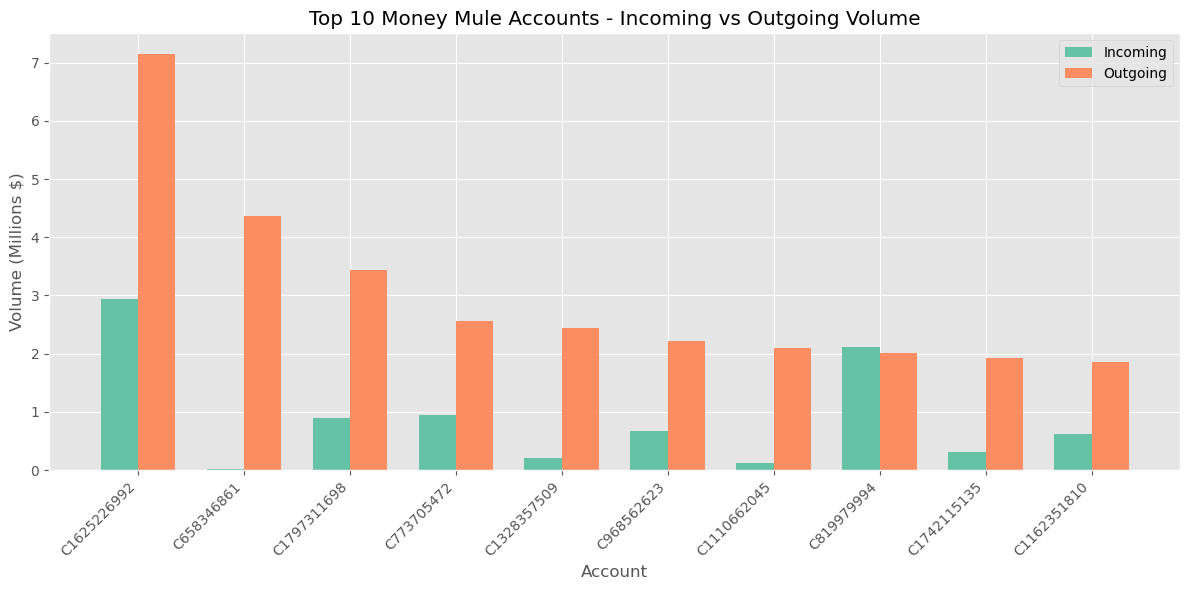

Money Mule Accounts Total Incoming Volume: $57,231,072.30
Money Mule Accounts Total Outgoing Volume: $101,799,738.58
Excess Outgoing Volume (Undocumented Sources): $44,568,666.28
Percentage of Undocumented Money: 43.78%


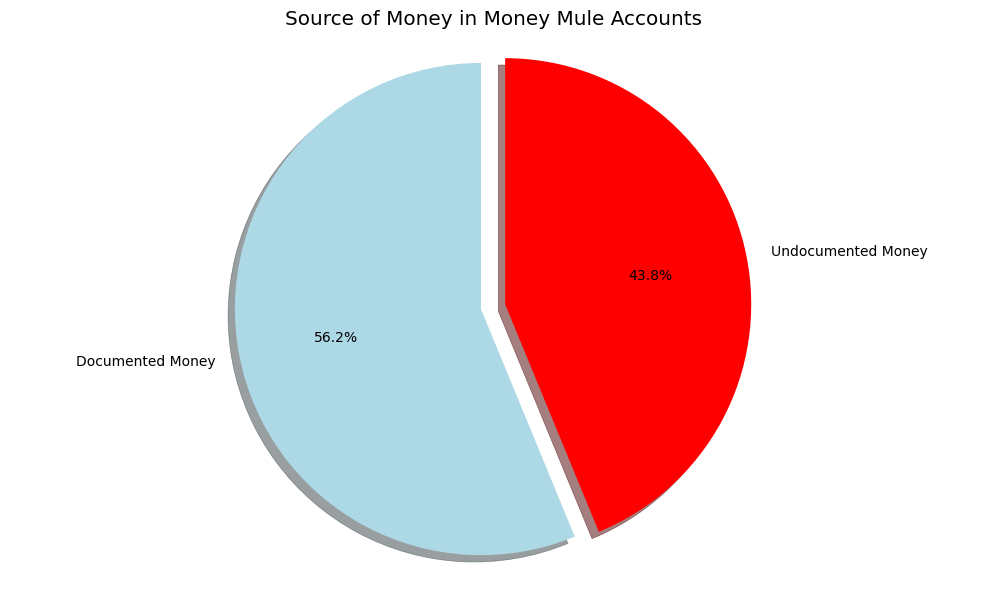

In [5]:
# Identify money mule accounts
def is_money_mule(row):
    return (
        row['incoming_count'] >= 1 and
        row['outgoing_count'] >= 1 and
        row['outgoing_volume'] > 0.5 * row['incoming_volume'] and
        row['retention_rate'] < 0.4 and
        row['incoming_volume'] > 10000.0
    )

mule_accounts = account_metrics[account_metrics.apply(is_money_mule, axis=1)].copy()
mule_accounts.sort_values('outgoing_volume', ascending=False, inplace=True)

print(f"Identified {len(mule_accounts)} money mule accounts")
mule_accounts.head(20)
# Plot top money mule accounts
plt.figure(figsize=(12, 6))
top_mules = mule_accounts.head(10)

bar_width = 0.35
x = np.arange(len(top_mules))

plt.bar(x - bar_width/2, top_mules['incoming_volume'] / 1e6, bar_width, label='Incoming')
plt.bar(x + bar_width/2, top_mules['outgoing_volume'] / 1e6, bar_width, label='Outgoing')

plt.xlabel('Account')
plt.ylabel('Volume (Millions $)')
plt.title('Top 10 Money Mule Accounts - Incoming vs Outgoing Volume')
plt.xticks(x, top_mules['account'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
# Calculate undocumented volume
excess_volume = mule_accounts['outgoing_volume'].sum() - mule_accounts['incoming_volume'].sum()

print(f"Money Mule Accounts Total Incoming Volume: ${mule_accounts['incoming_volume'].sum():,.2f}")
print(f"Money Mule Accounts Total Outgoing Volume: ${mule_accounts['outgoing_volume'].sum():,.2f}")
print(f"Excess Outgoing Volume (Undocumented Sources): ${excess_volume:,.2f}")
print(f"Percentage of Undocumented Money: {excess_volume / mule_accounts['outgoing_volume'].sum() * 100:.2f}%")
# Pie chart undocumented vs documented
plt.figure(figsize=(10, 6))
labels = ['Documented Money', 'Undocumented Money']
sizes = [mule_accounts['incoming_volume'].sum(), excess_volume]
colors = ['lightblue', 'red']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Source of Money in Money Mule Accounts')
plt.tight_layout()
plt.show()
